In [ ]:
# mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# installing the keras tuner
# reference - https://www.youtube.com/watch?v=OzLAdpqm35E&t=704s
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 4.6 MB/s 
     |████████████████████████████████| 1.6 MB 40.5 MB/s 


In [ ]:
# import libraries
import tensorflow as tf
import timeit
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import time
import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras import layers
from keras.layers import CuDNNGRU
from keras.layers import GRU
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import MaxPooling1D
from keras.layers import Embedding
from keras.models import Model
from keras.utils.vis_utils import plot_model
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import os
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.offline as py
import plotly.express as px
from plotly import tools
import plotly.figure_factory as ff
import warnings
from matplotlib import pyplot as plt
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# unzip the dataset
import os
zip_path = os.path.join(os.path.join('drive', 'My Drive', 'Dissertation'), 'df_news_combined.csv.zip')
!cp '{zip_path}' .
!yes|unzip -q df_news_combined.csv.zip
!rm df_news_combined.csv.zip
print(os.listdir(os.path.join('drive', 'My Drive', 'Dissertation')))

['df_news_combined.csv.zip', 'trails.ipynb', 'naivebayes_base_and_tuned.ipynb', 'xgboost_base_and_tuned.ipynb', 'random_forest_base_and_tuned.ipynb', 'stochastic_gradient_descent_base_and_tuned', 'data_collection_and_data_cleaning.ipynb', 'data_visualisation.ipynb', 'mlp_base_and_tuned.ipynb', 'cnn_base_and_tuned.ipynb', 'lstm_base_and_tuned.ipynb', 'gru_base_and_tuned.ipynb']


In [ ]:
# read the dataset
df_news_com = pd.read_csv('df_news_combined.csv')
df_news_com

,TITLE,ARTICLE LINK,AUTHOR,PUBLISHER,COUNTRY,CATEGORY,LANGUAGE,DESCRIPTION,IMAGE URL,VIDEO URL,DATE,GMT,POSTAG
0,"""Business duo turn over $70K a month with thei...",https://www.dailymail.co.uk/femail/article-107...,Unknown,Mail Online,United Kingdom,Food,English,business duo create home hair kit bridge gap b...,https://i.dailymail.co.uk/1s/2022/04/29/05/571...,Unknown,05/01/2022,00:16,"[('business', 'NN'), ('duo', 'NN'), ('created'..."
1,"""People Are Sharing ""Impulsive And Expensive"" ...",https://www.buzzfeed.com/fabianabuontempo/peop...,Unknown,Buzzfeed,United Kingdom,Food,English,definitely need love make confident secure hap...,https://img.buzzfeed.com/buzzfeed-static/stati...,Unknown,05/01/2022,00:25,"[('definitely', 'RB'), ('need', 'MD'), ('love'..."
2,"""Why You Shouldn't Butter The Pan When Making ...",https://www.buzzfeed.com/rossyoder/culinary-sc...,Unknown,Buzzfeed,United Kingdom,Food,English,class session view entire post,https://img.buzzfeed.com/buzzfeed-static/stati...,Unknown,05/01/2022,00:25,"[('class', 'NN'), ('session', 'NN'), ('view', ..."
3,"""Quaint beachside cottage on the Mornington Pe...",https://www.dailymail.co.uk/femail/homes/artic...,Unknown,Mail Online,United Kingdom,Food,English,ultra chic contemporary home lap pool tennis c...,https://i.dailymail.co.uk/1s/2022/04/29/07/571...,Unknown,05/01/2022,00:53,"[('ultra', 'JJ'), ('chic', 'JJ'), ('contempora..."
4,"""Viral Tiktok claims Sunnyboys were back at Wo...",https://www.dailymail.co.uk/femail/food/articl...,Unknown,Mail Online,United Kingdom,Food,English,australian shoppers send spin tiktok clip go v...,https://i.dailymail.co.uk/1s/2022/05/01/02/572...,Unknown,05/01/2022,01:32,"[('australian', 'JJ'), ('shoppers', 'NNS'), ('..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
823100,"""'New Zealand condemns Russias annexation atte...",http://www.voxy.co.nz/politics/5/407843,Unknown,Voxy,New Zealand,Politics,English,new zealand condemn unequivocally russias atte...,Unknown,Unknown,30/09/2022,23:02,"[('new', 'JJ'), ('zealand', 'NNP'), ('condemns..."
823101,"""Nigeria @ 62: So far, not so good""",https://punchng.com/nigeria-62-so-far-not-so-g...,Our Reporters,Punch,Nigeria,Politics,English,leke baiyewu abiodun sanusi x ray political hi...,Unknown,Unknown,30/09/2022,23:25,"[('leke', 'NN'), ('baiyewu', 'NN'), ('abiodun'..."
823102,"""Most Voters Say Trump Should Not Be Allowed T...",https://www.huffpost.com/entry/voters-donald-t...,Unknown,Huffpost,United States Of America,Politics,English,apparently go give know ongoing investigations...,Unknown,Unknown,30/09/2022,23:25,"[('apparently', 'RB'), ('go', 'VB'), ('given',..."
823103,"""Babayemi congratulates Adeleke on Supreme Cou...",https://punchng.com/babayemi-congratulates-ade...,Bola Bamigbola,Punch,Nigeria,Politics,English,former governorship aspirant platform people d...,Unknown,Unknown,30/09/2022,23:44,"[('former', 'JJ'), ('governorship', 'NN'), ('a..."


In [ ]:
# reference - https://note.nkmk.me/en/python-pandas-nan-judge-count/
# checking for the missing values
df_news_com.isnull().sum()
# note - the reason this dataset is showing null values again beacause it is converted in the zip file, so the null values occured automatically even after doing the data cleaning.
# note - the code is been adapted from the reference and it is modified

TITLE            0
ARTICLE LINK     0
AUTHOR          27
PUBLISHER        0
COUNTRY          0
CATEGORY         0
LANGUAGE         0
DESCRIPTION     91
IMAGE URL        0
VIDEO URL        0
DATE             0
GMT              0
POSTAG           0
dtype: int64

In [ ]:
# reference - https://www.geeksforgeeks.org/replace-nan-values-with-zeros-in-pandas-dataframe/
# replacing the null values with the unknown
df_news_com['AUTHOR'] = df_news_com['AUTHOR'].fillna('Unknown')
df_news_com['DESCRIPTION'] = df_news_com['DESCRIPTION'].fillna('Unknown')
# note - the code is been adapted from the reference and it is modified

In [ ]:
# reference - https://note.nkmk.me/en/python-pandas-nan-judge-count/
# checking for the missing values
df_news_com.isnull().sum()
# note - the code is been adapted from the reference and it is modified

TITLE           0
ARTICLE LINK    0
AUTHOR          0
PUBLISHER       0
COUNTRY         0
CATEGORY        0
LANGUAGE        0
DESCRIPTION     0
IMAGE URL       0
VIDEO URL       0
DATE            0
GMT             0
POSTAG          0
dtype: int64

In [ ]:
# getting the info
df_news_com.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823105 entries, 0 to 823104
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   TITLE         823105 non-null  object
 1   ARTICLE LINK  823105 non-null  object
 2   AUTHOR        823105 non-null  object
 3   PUBLISHER     823105 non-null  object
 4   COUNTRY       823105 non-null  object
 5   CATEGORY      823105 non-null  object
 6   LANGUAGE      823105 non-null  object
 7   DESCRIPTION   823105 non-null  object
 8   IMAGE URL     823105 non-null  object
 9   VIDEO URL     823105 non-null  object
 10  DATE          823105 non-null  object
 11  GMT           823105 non-null  object
 12  POSTAG        823105 non-null  object
dtypes: object(13)
memory usage: 81.6+ MB


In [ ]:
# reference - https://www.folkstalk.com/tech/create-new-dataframe-from-existing-dataframe-pandas-with-code-examples/
# creating separate dataframe of columns description and category
df_news_com1 = df_news_com[['DESCRIPTION', 'CATEGORY']].copy()
df_news_com1.head()
# note - the code is been adapted from the reference and it is modified

,DESCRIPTION,CATEGORY
0,business duo create home hair kit bridge gap b...,Food
1,definitely need love make confident secure hap...,Food
2,class session view entire post,Food
3,ultra chic contemporary home lap pool tennis c...,Food
4,australian shoppers send spin tiktok clip go v...,Food


In [ ]:
# reference - https://www.geeksforgeeks.org/ml-label-encoding-of-datasets-in-python/
# label encoding the categories
label_encoder_category = preprocessing.LabelEncoder()
df_news_com1['CATEGORY']= label_encoder_category.fit_transform(df_news_com1['CATEGORY'])
df_news_com1.head()
# note - the code is been adapted from the reference and it is modified

,DESCRIPTION,CATEGORY
0,business duo create home hair kit bridge gap b...,3
1,definitely need love make confident secure hap...,3
2,class session view entire post,3
3,ultra chic contemporary home lap pool tennis c...,3
4,australian shoppers send spin tiktok clip go v...,3


In [ ]:
# reference - https://www.folkstalk.com/2022/10/number-of-total-words-in-cell-pandas-with-code-examples.html
# added the column sentence length which shows the length of the sentence
df_news_com1['SENTENCE_LENGTH'] = df_news_com1['DESCRIPTION'].apply(lambda x:len(str(x).split())) 
sentence_length_max = df_news_com1['SENTENCE_LENGTH'].max()
sentence_length_max
# note - the code is been adapted from the reference and it is modified

3732

### GRU Base Model

In [ ]:
# reference - https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# reference - https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17
# this class makes it possible to "vectorize" a body of text by converting it into a series of numbers.
maximum_num_words = 10000
tokenizer = Tokenizer(num_words = maximum_num_words)
tokenizer.fit_on_texts(df_news_com1['DESCRIPTION'].values)
# note - the code is been adapted from the references and it is modified

In [ ]:
# this class makes it possible to "vectorize" a body of text by converting it into a series of numbers.
x_gru = tokenizer.texts_to_sequences(df_news_com1['DESCRIPTION'].values)
x_gru = pad_sequences(x_gru, maxlen=3800)
# note - the code is been adapted from my lstm code and only word x_lstm is replaced with x_gru

In [ ]:
# get the shape of the input side
x_gru.shape

(823105, 3800)

In [ ]:
# values of the categories
y_gru = pd.get_dummies(df_news_com1['CATEGORY']).values
# note - the code is been adapted from my lstm code and only word y_lstm is replaced with y_gru

In [ ]:
# get the shape of the output side
y_gru.shape

(823105, 7)

In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# splitting into training and testing
x_train_gru, x_test_gru, y_train_gru, y_test_gru = train_test_split(x_gru, y_gru, test_size=0.2, shuffle = False , random_state = 0)
# note - the code is been adapted from the reference and it is modified

In [ ]:
# create the gru base model
embedding_dim = 128
feature_size = 15000
model_gru = Sequential()
model_gru.add(layers.Embedding( feature_size,embedding_dim, input_length=x_gru.shape[1])) # embedding layer with feature size, embedding dimension and input length
model_gru.add(Dropout(0.1)) # first dropout layer
model_gru.add(CuDNNGRU(128)) # CuDNNGRU layer
model_gru.add(Dense(64, activation = 'sigmoid')) # first dense layer
model_gru.add(Dropout(0.1)) # second dropout layer
model_gru.add(Dense(7, activation='softmax')) # second dense layer
model_gru.summary()
# note - the code is been adapted from my lstm code and CuDNNGRU and sigmoid activation is introduced instead of the CuDNNLSTM and relu

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3800, 128)         1920000   
                                                                 
 dropout (Dropout)           (None, 3800, 128)         0         
                                                                 
 cu_dnngru (CuDNNGRU)        (None, 128)               99072     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 455       
                                                                 
Total params: 2,027,783
Trainable params: 2,027,783
Non-

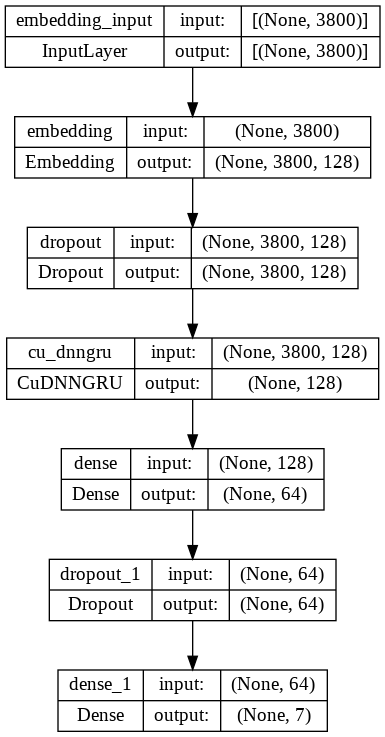

In [ ]:
# reference - https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
# print the gru base model
plot_model(model_gru, to_file='model_plot_gru.png', show_shapes=True, show_layer_names=True)
# note - the code is been adapted from the reference and it is modified.

In [ ]:
# applying the the loss, otimizer and training the model
model_gru.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
gru_start_time = time.time()
model_gru_history = model_gru.fit(x_train_gru, y_train_gru,
                     epochs=5,
                     verbose=False,
                     validation_split=0.1,
                     batch_size=512,callbacks=[EarlyStopping(patience=100)])
gru_stop_time = time.time()
# note - the code is been adapted from my lstm code and it is modified

In [ ]:
# training loss and accuracy of the gru base model
# reference - https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tuner
loss, accuracy = model_gru.evaluate(x_train_gru, y_train_gru)

20578/20578 [==============================] - 1665s 81ms/step - loss: 0.2044 - accuracy: 0.9313


In [ ]:
# reference - https://plotly.com/python/line-and-scatter/
# reference - https://plotly.com/python/reference/layout/
# reference - https://www.kaggle.com/code/sercanyesiloz/plotly-tutorial/notebook#Line%20Charts
# reference - https://linuxhint.com/plotly-graph-objects-scatter/
# plotting the training loss
gru_model_training_loss = model_gru_history.history['loss']
epochs = [1,2,3,4,5]
df_model_gru_history = go.Scatter(x = epochs,
                     y = gru_model_training_loss ,
                     mode="markers+lines",
                     marker = dict(color = 'red'))
gru_layout = go.Layout(title={'text' : 'GRU MODEL TRAINING LOSS'},xaxis=dict(title = 'EPOCHS'),yaxis=dict(title='TRAINING LOSS'),
                   template = 'plotly_dark')


fig = go.Figure(data = df_model_gru_history,layout=gru_layout)
fig.update_layout(width=500,
    height=500
)
iplot(fig)
# note - the code is been adapted from the references and it is modified

In [ ]:
# reference - https://plotly.com/python/line-and-scatter/
# reference - https://plotly.com/python/reference/layout/
# reference - https://www.kaggle.com/code/sercanyesiloz/plotly-tutorial/notebook#Line%20Charts
# reference - https://linuxhint.com/plotly-graph-objects-scatter/
# plotting the training accuracy
gru_model_training_accuracy = model_gru_history.history['accuracy']
epochs = [1,2,3,4,5]
df_model_gru_history = go.Scatter(x = epochs,
                     y = gru_model_training_accuracy ,
                     mode="markers+lines",
                     marker = dict(color = 'limegreen'))
gru_layout = go.Layout(title={'text' : 'GRU MODEL TRAINING ACCURACY'},xaxis=dict(title = 'EPOCHS'),yaxis=dict(title='TRAINING ACCURACY'),
                   template = 'plotly_dark')

fig = go.Figure(data = df_model_gru_history,layout=gru_layout)
fig.update_layout(width=500,
    height=500
)
iplot(fig)
# note - the code is been adapted from the references and it is modified

In [ ]:
# predict the gru base model
gru_train_predict = model_gru.predict(x_train_gru)

20578/20578 [==============================] - 1588s 77ms/step


In [ ]:
# reference - https://datascience.stackexchange.com/questions/93751/valueerror-classification-metrics-cant-handle-a-mix-of-multilabel-indicator-an
y_train_gru_arg=np.argmax(y_train_gru,axis=1)
y_train_pred_gru = np.argmax(gru_train_predict,axis=1)
# note - the code is been adapted from the references and it is modified
# note - I added this code because I was getting the value error of mix multilabel

### Training side of gru model : getting precision,recall,f1,fbeta,mae,mse,rmse,training time

In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
# generating the classification report
from sklearn import metrics
print(metrics.classification_report(y_train_gru_arg, y_train_pred_gru))
# note - the code is been adapted from the references and it is modified

              precision    recall  f1-score   support

           0       0.90      0.94      0.92    184194
           1       0.95      0.86      0.90    145217
           3       0.63      0.44      0.52      3756
           4       0.84      0.82      0.83     40210
           6       0.96      0.98      0.97    285107

    accuracy                           0.93    658484
   macro avg       0.86      0.81      0.83    658484
weighted avg       0.93      0.93      0.93    658484



In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
# calculate the precision score
print(precision_score(y_train_gru_arg, y_train_pred_gru,average='macro'))
# note - the code is been adapted from the references and it is modified

0.8560956263291466


In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
# calculate the recall score
print(recall_score(y_train_gru_arg, y_train_pred_gru,average='macro'))
# note - the code is been adapted from the references and it is modified

0.8098828029502233


In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
# calculate the f1 score
print(f1_score(y_train_gru_arg, y_train_pred_gru,average='macro'))
# note - the code is been adapted from the references and it is modified

0.8289134140841481


In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html
# calculate the fbeta score
print(fbeta_score(y_train_gru_arg, y_train_pred_gru,average='macro', beta = 0.7))
# note - the code is been adapted from the references and it is modified

0.8370892484488289


In [ ]:
# calculate the MSE
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
print(mean_squared_error(y_train_gru_arg, y_train_pred_gru,squared=True))
# note - the code is been adapted from the references and it is modified

0.9823731480187825


In [ ]:
# calculate the RMSE
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
print(mean_squared_error(y_train_gru_arg, y_train_pred_gru,squared=False))
# note - the code is been adapted from the references and it is modified

0.991147389654426


In [ ]:
# calculate the train time
training_time_gru = gru_stop_time - gru_start_time
training_time_gru

1727.8939850330353

### Testing side of gru model : getting precision,recall,f1,fbeta,mae,mse,rmse

In [ ]:
# loss and accuracy of the gru base model
# reference - https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tuner
loss, accuracy = model_gru.evaluate(x_test_gru, y_test_gru)

5145/5145 [==============================] - 418s 81ms/step - loss: 3.3121 - accuracy: 0.5772


In [ ]:
# predict the gru base model
gru_test_predict = model_gru.predict(x_test_gru)


5145/5145 [==============================] - 400s 78ms/step


In [ ]:
# reference - https://datascience.stackexchange.com/questions/93751/valueerror-classification-metrics-cant-handle-a-mix-of-multilabel-indicator-an
y_test_gru_arg=np.argmax(y_test_gru,axis=1)
y_test_pred_gru = np.argmax(gru_test_predict,axis=1)
# note - the code is been adapted from the references and it is modified
# note - I added this code because I was getting the value error of mix multilabel

In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
# generating the classification report
from sklearn import metrics
print(metrics.classification_report(y_test_gru_arg, y_test_pred_gru))
# note - the code is been adapted from the references and it is modified

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.93      0.79      0.86    119609
           2       0.00      0.00      0.00      7281
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00     37731
           6       0.00      0.00      0.00         0

    accuracy                           0.58    164621
   macro avg       0.13      0.11      0.12    164621
weighted avg       0.68      0.58      0.62    164621



In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
# calculate the precision score
print(precision_score(y_test_gru_arg, y_test_pred_gru,average='macro'))
# note - the code is been adapted from the references and it is modified

0.1333705740925021


In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
# calculate the recall score
print(recall_score(y_test_gru_arg, y_test_pred_gru,average='macro'))
# note - the code is been adapted from the references and it is modified

0.11349360953487733


In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
# calculate the f1 score
print(f1_score(y_test_gru_arg, y_test_pred_gru,average='macro'))
# note - the code is been adapted from the references and it is modified

0.12263186694060438


In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html
# calculate the fbeta score
print(fbeta_score(y_test_gru_arg, y_test_pred_gru,average='macro', beta = 0.7))
# note - the code is been adapted from the references and it is modified

0.12610735913386598


In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html
# calculate the MAE
print(mean_absolute_error(y_test_gru_arg, y_test_pred_gru))
# note - the code is been adapted from the references and it is modified

1.4040735993585265


In [ ]:
# calculate the MSE
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
print(mean_squared_error(y_test_gru_arg, y_test_pred_gru,squared=True))
# note - the code is been adapted from the references and it is modified

5.999757017634445


In [ ]:
# calculate the RMSE
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
print(mean_squared_error(y_test_gru_arg, y_test_pred_gru,squared=False))
# note - the code is been adapted from the references and it is modified

2.4494401437133435


### GRU Tuned Model



In [ ]:
# define the model for the hyperparameters
def create_model(hyper_para):
  gru_model_tuned = keras.Sequential()
  gru_model_tuned.add(layers.Embedding(input_dim = hyper_para.Int('input_dim', min_value = 15000,max_value = 20000 , step = 5000 ),output_dim = hyper_para.Int('output_dim',min_value=100,max_value=200,step = 100),input_length = x_gru.shape[1] ))
  gru_model_tuned.add(Dropout(0.1))
  gru_model_tuned.add(CuDNNGRU(128))
  gru_model_tuned.add(layers.Dense(units=hyper_para.Int('units',min_value = 128, max_value = 256, step = 128),activation = 'sigmoid'))
  gru_model_tuned.add(Dropout(0.1))
  gru_model_tuned.add(layers.Dense(7, activation='softmax'))
  gru_model_tuned.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(hyper_para.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])),metrics=['accuracy'])
  return gru_model_tuned
# note - the code is been adapted from my lstm code and it is modified


### GRU Tuning with Hyperband

In [ ]:
# setting the hyperparameters for hyperband
from kerastuner.tuners import Hyperband
gru_hyperband_tuner = Hyperband(
    create_model,
    max_epochs= 1,
    hyperband_iterations=1,
    overwrite = True,
    objective = 'accuracy',
    factor = 2
)
gru_hyperband_tuner.search_space_summary()
# note - the code is been adapted from my lstm code and it is modified

Search space summary
Default search space size: 4
input_dim (Int)
{'default': None, 'conditions': [], 'min_value': 15000, 'max_value': 20000, 'step': 5000, 'sampling': None}
output_dim (Int)
{'default': None, 'conditions': [], 'min_value': 100, 'max_value': 200, 'step': 100, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 128, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
# create the earlystopping
early_stop_gru = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy',patience=100)
# note - the code is been adapted from my lstm code and it is modified

In [ ]:
# searching for best hyperparameters
gru_hyperband_tuner.search(x_train_gru, y_train_gru, epochs=1, validation_split=0.1, callbacks=[early_stop_gru],batch_size=512)
# note - the code is been adapted from my lstm code and it is modified
# note - parameters are randomly chosen
# note - epoch only chosen 1 because the session was crashing repeatedly as the cudnngru require huge amount of ram

Trial 1 Complete [00h 06m 18s]
accuracy: 0.8998202681541443

Best accuracy So Far: 0.8998202681541443
Total elapsed time: 00h 06m 18s


In [ ]:
# best hyperparameters
best_hyperparameters_gru = gru_hyperband_tuner.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters_gru.values
# note - the code is been adapted from my lstm code and it is modified

{'input_dim': 15000,
 'output_dim': 100,
 'units': 256,
 'learning_rate': 0.01,
 'tuner/epochs': 1,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [ ]:
# creating 1st gru model(epochs=10 and batch_size=512) with best hyperparameters
model_gru_tuned1 = gru_hyperband_tuner.hypermodel.build(best_hyperparameters_gru)
model_gru_tuned1_history = model_gru_tuned1.fit(x_train_gru, y_train_gru,validation_split=0.1,
                     epochs=10,
                     verbose=False,
                     batch_size=512,callbacks=[EarlyStopping(monitor = 'accuracy',patience=100)])
# note - the code is been created from my cnn program as per the gru model

In [ ]:
# training loss and accuracy of the 1st tuned gru model
loss, accuracy = model_gru_tuned1.evaluate(x_train_gru, y_train_gru)
# note - the code is been created from my cnn program as per the gru model

20578/20578 [==============================] - 1659s 81ms/step - loss: nan - accuracy: 0.2797


In [ ]:
# testing loss and accuracy of the 1st tuned gru model
loss, accuracy = model_gru_tuned1.evaluate(x_test_gru, y_test_gru)
# note - the code is been created from my cnn program as per the gru model

5145/5145 [==============================] - 420s 82ms/step - loss: nan - accuracy: 0.0000e+00


In [ ]:
# creating 2nd gru model(epochs=15 and batch_size=512) with best hyperparameters
model_gru_tuned2 = gru_hyperband_tuner.hypermodel.build(best_hyperparameters_gru)
model_gru_tuned2_history = model_gru_tuned2.fit(x_train_gru, y_train_gru,validation_split=0.1,
                     epochs=15,
                     verbose=False,
                     batch_size=512,callbacks=[EarlyStopping(monitor = 'accuracy',patience=100)])
# note - the code is been created from my cnn program as per the gru model

In [ ]:
# training loss and accuracy of the 1st tuned gru model
loss, accuracy = model_gru_tuned2.evaluate(x_train_gru, y_train_gru)
# note - the code is been created from my cnn program as per the gru model

20578/20578 [==============================] - 1661s 81ms/step - loss: nan - accuracy: 0.2797


In [ ]:
# testing loss and accuracy of the 1st tuned gru model
loss, accuracy = model_gru_tuned2.evaluate(x_test_gru, y_test_gru)
# note - the code is been created from my cnn program as per the gru model

5145/5145 [==============================] - 415s 81ms/step - loss: nan - accuracy: 0.0000e+00


In [ ]:
# setting random search hyperparameters
from kerastuner.tuners import RandomSearch
gru_randomsearch_tuner = RandomSearch(
    create_model,
    max_trials=3,
    objective='accuracy',
)
gru_randomsearch_tuner.search_space_summary()
# note - the code is been adapted from my cnn code and it is modified

Search space summary
Default search space size: 4
input_dim (Int)
{'default': None, 'conditions': [], 'min_value': 15000, 'max_value': 20000, 'step': 5000, 'sampling': None}
output_dim (Int)
{'default': None, 'conditions': [], 'min_value': 100, 'max_value': 200, 'step': 100, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 128, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
# create the earlystopping
early_stop_gru1 = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy',patience=100)
# note - the code is been adapted from my cnn code and it is modified

In [ ]:
# searching for best hyperparameters
gru_randomsearch_tuner.search(x_train_gru, y_train_gru, epochs=1, validation_split=0.1, callbacks=[early_stop_gru1],batch_size=512)
# note - the code is been adapted from my cnn code and it is modified

Trial 3 Complete [00h 05m 50s]
accuracy: 0.8995469212532043

Best accuracy So Far: 0.8998202681541443
Total elapsed time: 00h 11m 56s


In [ ]:
# best hyperparameters
best_hyperparameters_gru1 = gru_randomsearch_tuner.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters_gru1.values
# note - the code is been adapted from my lstm code and it is modified

{'input_dim': 15000,
 'output_dim': 100,
 'units': 256,
 'learning_rate': 0.01,
 'tuner/epochs': 1,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [ ]:
# creating 3rd gru model(epochs=10 and batch_size=512) with best hyperparameters
model_gru_tuned3 = gru_randomsearch_tuner.hypermodel.build(best_hyperparameters_gru1)
model_gru_tuned3_history = model_gru_tuned3.fit(x_train_gru, y_train_gru,validation_split=0.1,
                     epochs=10,
                     verbose=False,
                     batch_size=512,callbacks=[EarlyStopping(monitor = 'accuracy',patience=100)])
# note - the code is been created from my cnn program as per the gru model

In [ ]:
# training loss and accuracy of the 3rd tuned gru model
loss, accuracy = model_gru_tuned3.evaluate(x_train_gru, y_train_gru)
# note - the code is been created from my cnn program as per the gru model

20578/20578 [==============================] - 1660s 81ms/step - loss: nan - accuracy: 0.2797


In [ ]:
# testing loss and accuracy of the 3rd tuned gru model
loss, accuracy = model_gru_tuned3.evaluate(x_test_gru, y_test_gru)
# note - the code is been created from my cnn program as per the gru model

5145/5145 [==============================] - 415s 81ms/step - loss: nan - accuracy: 0.0000e+00


In [ ]:
# creating 4th gru model(epochs=10 and batch_size=512) with best hyperparameters
model_gru_tuned4 = gru_randomsearch_tuner.hypermodel.build(best_hyperparameters_gru1)
model_gru_tuned4_history = model_gru_tuned4.fit(x_train_gru, y_train_gru,validation_split=0.1,
                     epochs=15,
                     verbose=False,
                     batch_size=512,callbacks=[EarlyStopping(monitor = 'accuracy',patience=100)])
# note - the code is been created from my cnn program as per the gru model

In [ ]:
# training loss and accuracy of the 4th tuned gru model
loss, accuracy = model_gru_tuned4.evaluate(x_train_gru, y_train_gru)
# note - the code is been created from my cnn program as per the gru model

20578/20578 [==============================] - 1675s 81ms/step - loss: nan - accuracy: 0.2797


In [ ]:
# testing loss and accuracy of the 4th tuned gru model
loss, accuracy = model_gru_tuned4.evaluate(x_test_gru, y_test_gru)
# note - the code is been created from my cnn program as per the gru model

5145/5145 [==============================] - 419s 81ms/step - loss: nan - accuracy: 0.0000e+00
